# 0. Cone Activation Function

This notebook aims to investigate the performance of the newly proposed "cone activation function" in the paper [A Significantly Better Class of Activation Functions Than ReLU Like Activation Functions](https://arxiv.org/pdf/2405.04459) [1].
Formally, the cone acitivation function is defined as follows:
$$ \text{cone}(t, \beta) = 1 - |1-t|^{\beta} $$
for some hyper-parameter $\beta>0$.

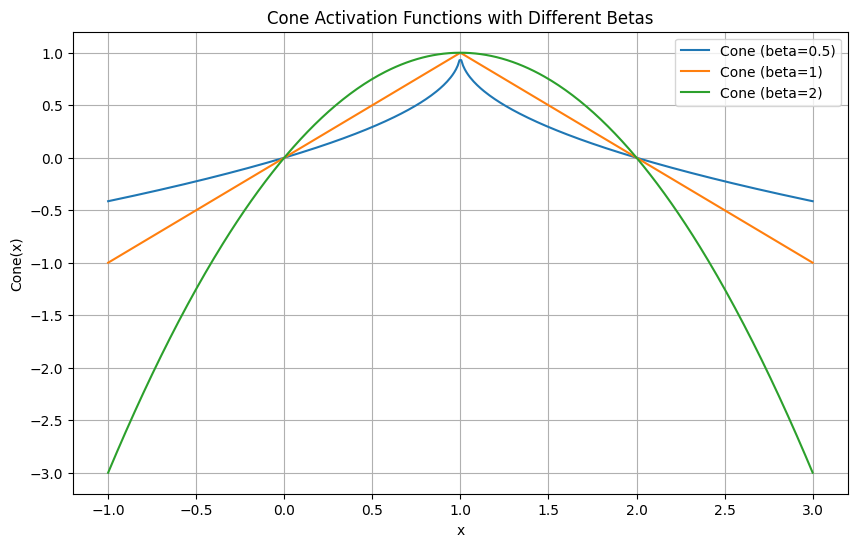

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Cone activation function
def cone(x, beta):
    return 1 - np.abs(1 - x)**beta

# Generate a range of input values
x = np.linspace(-1, 3, 400)

# Define a list of beta values to plot
beta_values = [0.5, 1, 2]

# Plot Cone functions for different beta values
plt.figure(figsize=(10, 6))
for beta in beta_values:
    y = cone(x, beta)
    plt.plot(x, y, label='Cone (beta={})'.format(beta))

plt.title('Cone Activation Functions with Different Betas')
plt.xlabel('x')
plt.ylabel('Cone(x)')
plt.legend()
plt.grid(True)
plt.show()


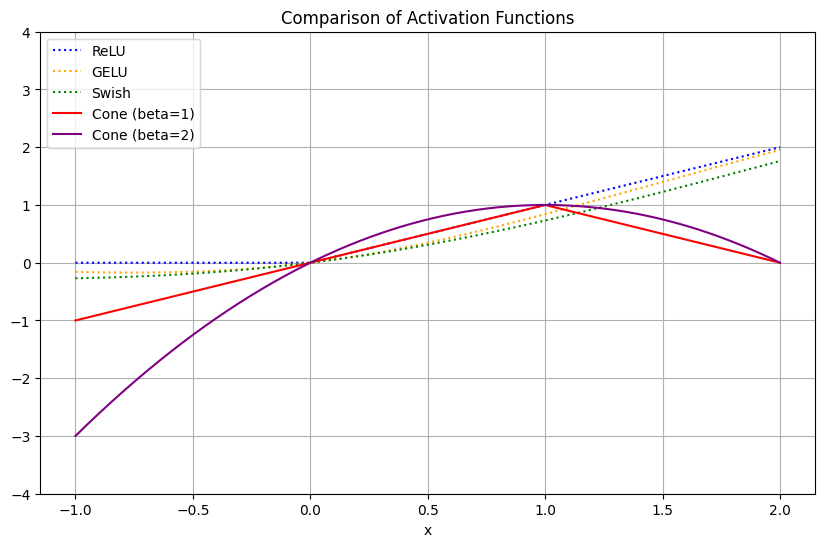

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def gelu(x):
    return 0.5 * x * (1 + torch.erf(x / np.sqrt(2)))

def swish(x):
    return x * torch.sigmoid(x)

def cone(x, beta):
    return 1 - torch.abs(1 - x)**beta

# define the smoothened cone later
# def cone1(x, beta, mu):
#    return 1 - abs1(1 - x, mu)**beta

#def cone2(x, beta, mu):
#    return 1 - abs2(1 - x, mu)**beta

# Define abs1 and abs2 functions
#def abs1(x, mu):
#    return x * torch.erf(mu * x)

#def abs2(x, mu):
#    return torch.sqrt(x**2 + mu**2)

# Define range and step size
x_values = np.linspace(-1, 2, 1000)

# Plot activation functions
plt.figure(figsize=(10, 6))

plt.plot(x_values, relu(x_values), label='ReLU', color='blue', linestyle = ':')
plt.plot(x_values, gelu(torch.tensor(x_values, dtype=torch.float32)).numpy(), label='GELU', color='orange', linestyle = ':')
plt.plot(x_values, swish(torch.tensor(x_values, dtype=torch.float32)).numpy(), label='Swish', color='green', linestyle = ':')

beta_values = [1,2]
colors = ['red', 'purple', 'brown']

for beta, color in zip(beta_values, colors):
    plt.plot(x_values, cone(torch.tensor(x_values, dtype=torch.float32), beta).numpy(), label=f'Cone (beta={beta})', color=color)
    #plt.plot(x_values, cone1(torch.tensor(x_values, dtype=torch.float32), beta, 1).numpy(), label=f'Cone1 (beta={beta})', linestyle='dashed', color=color)
    #plt.plot(x_values, cone2(torch.tensor(x_values, dtype=torch.float32), beta, 1).numpy(), label=f'Cone2 (beta={beta})', linestyle='dotted', color=color)

plt.xlabel('x')
#plt.ylabel('Activation Value')
plt.ylim((-4,4))
plt.title('Comparison of Activation Functions')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

Note that the intuition behind the cone AF is completely different from the ReLU-type of AF:
- The cone AF is positive only on the hyper-strip $t\in(0,2)$,  while ReLU on the hyperplane $t>0$.
- range(cone)$=(-\infty,1]$, while range(ReLU)$=[0,+\infty)$.
- $\lim_{t\to-\infty} \text{cone}(t)=-\infty$, $\lim_{t\to+\infty} \text{cone}(t)=-\infty$ while $\lim_{t\to-\infty} \text{ReLU}(t)=0$, $\lim_{t\to+\infty} \text{ReLU}(t)/t=1$.

# 1. First Glimpse on the Performance

It is reported in the paper [1] that cone is significantly better than ReLU in image classification task with data sets CIFAR10 and Imaginette, where the interesetd object is the AF applied in the last MLP layer of the CNN architecture.

To begin our investigation, we conduct experiments using a synthetic data set of a regression task with 1000 samples, feature dimension of 20 and noise level of 0.1. We simply train the MLPs with different AF using ADAM as optimizer, which is also used in the paper. In the paper, the network is only trained for 30 epochs, which is too few. We extend the training to 400 epochs.



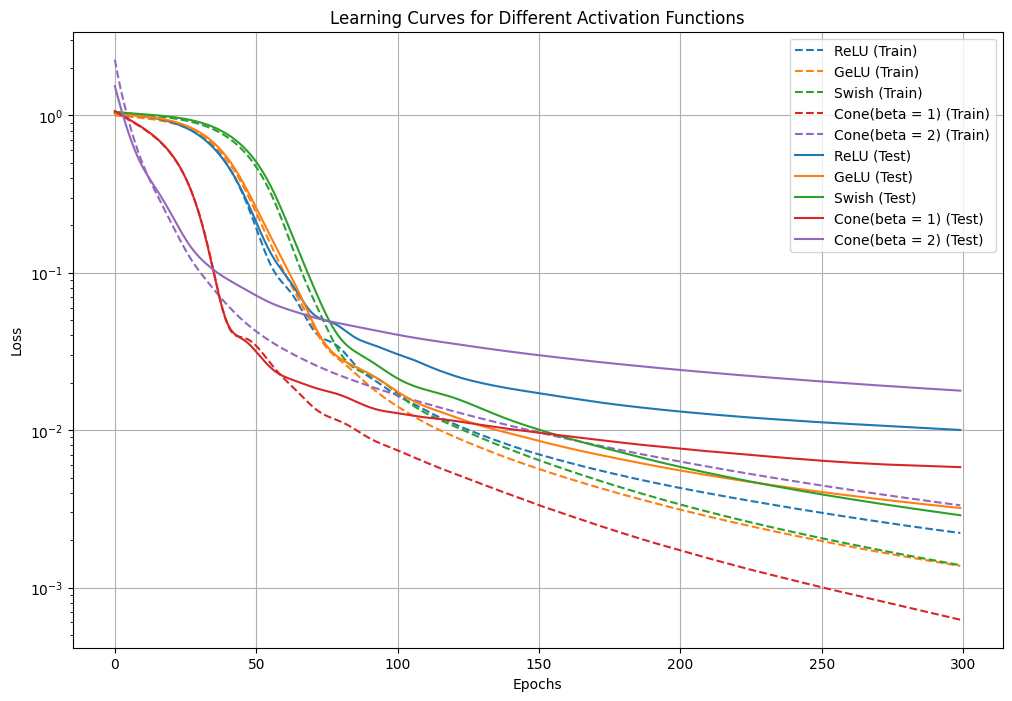

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define custom activation functions
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

activation_functions = {
    "ReLU": nn.ReLU(),
    "GeLU": nn.GELU(),
    "Swish": Swish(),
    "Cone(beta = 1)": Cone(beta = 1),
    "Cone(beta = 2)": Cone(beta = 2)
}

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3

# Training function
def train_model(activation_name, num_epochs=100, learning_rate=0.001):
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_functions[activation_name]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test).squeeze()
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        #print(f"Activation: {activation_name}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses

num_epochs = 300
learning_rate = 0.001

train_losses_dict = {}
test_losses_dict = {}

for i, activation_name in enumerate(activation_functions.keys()):
    #print(f"Training model with {activation_name} activation...")
    train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()


From the above plot, we can observe the followings:
- in epoch 0-50, the learning curves of cones(beta = 1,2) decay very fast, while that of Swish the slowest.
- in epoch 50-100, the learning curves of cones starts to flatten, while these of ReLU-type AF steepen.
- in epoch >100, we can see cone(beta = 1) achieves excellent train loss but the gap between the train loss and the test loss is very huge, indicating cone suffers from overfitting issues. This suggests regularization might help training with cone MLP.
- This experiment validates the results in paper [1] that cone(beta=1) behaves significatnly better than ReLU. However, from our experiment, cone(beta=2) has terrible performance, contradicting the findings in paper [1]. This might be due to the exploding gradient of the quadratic function. To move on, we only consider cone(beta=1) in most of our following experiments.
- Although cone beats ReLU, in many realistic scenarios, many state-of-the-art neural networks are equipped with GeLU or Swish instead of ReLU. However, from the experiment above, Swish is still the best AF in test performance, despite slow initial learning curve decay.

# 2. Smooth Cone

The failure of cone(beta=2) and the success of smoothened ReLU-type AF like GeLU/Swish tempt us to smoothen cone(beta=1) in a better way. Since cone(beta=1) beats ReLU, a correctly smoothened cone might be able to beat a smoothened ReLU like Swish.

Following this idea, we found the paper [SMU: smooth activation function for deep networks using smoothing maximum technique](https://arxiv.org/abs/2111.04682) [2] which formulated a smoothening technique and invented another AF, called the Smooth Maximum Unit (SMU) and claimed to beat Swish in image classification task. The paper [2] also recovered GeLU as a special case of SMU, hinting this might be a good method for us to smoothen cone as well.

According to [2], the maximum function can be expressed in absolute values:
$$ \max \{t_1, t_2 \} = \frac{t_1+t_2 - |t_1-t_2|}{2}.$$
Hence to smoothen ReLU is equivalent to smoothen the absolute value. To this end, [2] proposed approximating the absolute value $|t|$ by the two functions:
$$ \phi_1 (t,\mu) = t \cdot \text{erf}(\mu t),\quad \phi_2 (t,\mu) = \sqrt{t^2+\mu^2}$$
where $\mu>0$ is a hyperparameter, and $\text{erf}$ is the error function $\text{erf}(t) = \frac{2}{\sqrt{\pi}} \int_0^t e^{-s^2}ds$.

Note that $\phi_1(t,\mu) < |t| < \phi_2 (t,\mu),\forall t,\mu.$

In [2], $\mu$ is considered as a trainable parameter when defining SMU which beats Swish.

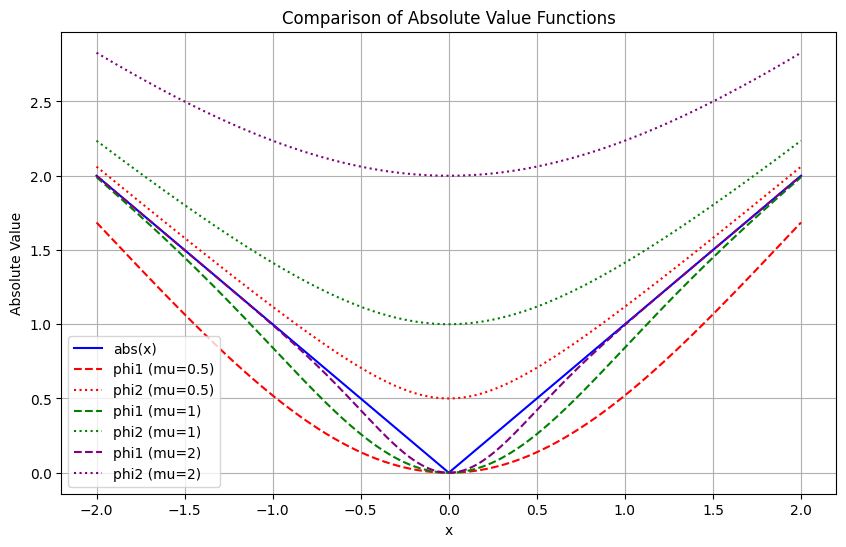

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define abs1 and abs2 functions
def abs1(x, mu):
    return x * torch.erf(mu * x)

def abs2(x, mu):
    return torch.sqrt(x**2 + mu**2)

# Define abs function (absolute value)
def abs(x):
    return np.abs(x)

# Define range and step size
x_values = np.linspace(-2, 2, 1000)

# Plot absolute value function
plt.figure(figsize=(10, 6))

plt.plot(x_values, abs(x_values), label='abs(x)', color='blue')

# Plot abs1 and abs2 functions with different values of mu
mu_values = [0.5, 1, 2]
colors = ['red', 'green', 'purple']

for mu, color in zip(mu_values, colors):
    plt.plot(x_values, abs1(torch.tensor(x_values, dtype=torch.float32), mu).numpy(), label=f'phi1 (mu={mu})', linestyle='dashed', color=color)
    plt.plot(x_values, abs2(torch.tensor(x_values, dtype=torch.float32), mu).numpy(), label=f'phi2 (mu={mu})', linestyle='dotted', color=color)

plt.xlabel('x')
plt.ylabel('Absolute Value')
plt.title('Comparison of Absolute Value Functions')
plt.legend()
plt.grid(True)
plt.show()

Hence, we can define the smooth cones as follows:

$$ \text{cone}_1(t,\beta,\mu) = 1 - \phi_1(1-t,\mu)^\beta, \text{cone}_2(t,\beta,\mu) = 1 - \phi_2(1-t,\mu)^\beta $$
for any $t\in\mathbb{R}$ and $\beta, \mu>0$.

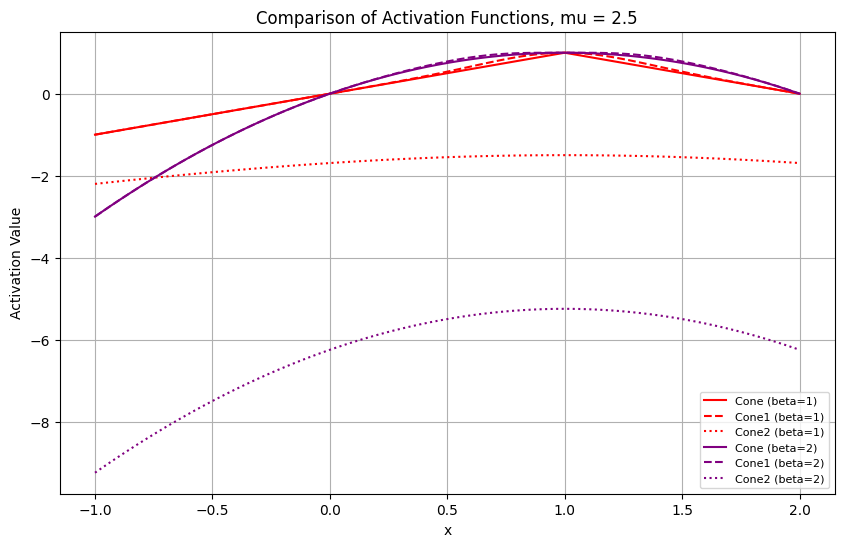

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def gelu(x):
    return 0.5 * x * (1 + torch.erf(x / np.sqrt(2)))

def swish(x):
    return x * torch.sigmoid(x)

def cone(x, beta):
    return 1 - torch.abs(1 - x)**beta

def cone1(x, beta, mu):
    return 1 - abs1(1 - x, mu)**beta

def cone2(x, beta, mu):
    return 1 - abs2(1 - x, mu)**beta

# Define abs1 and abs2 functions
def abs1(x, mu):
    return x * torch.erf(mu * x)

def abs2(x, mu):
    return torch.sqrt(x**2 + mu**2)

# Define range and step size
x_values = np.linspace(-1, 2, 100)

# Plot activation functions
plt.figure(figsize=(10, 6))

#plt.plot(x_values, relu(x_values), label='ReLU', color='blue')
#plt.plot(x_values, gelu(torch.tensor(x_values, dtype=torch.float32)).numpy(), label='GELU', color='orange')
#plt.plot(x_values, swish(torch.tensor(x_values, dtype=torch.float32)).numpy(), label='Swish', color='green')

beta_values = [1,2]
colors = ['red', 'purple', 'brown']
mu = 2.5

for beta, color in zip(beta_values, colors):
    plt.plot(x_values, cone(torch.tensor(x_values, dtype=torch.float32), beta).numpy(), label=f'Cone (beta={beta})', color=color)
    plt.plot(x_values, cone1(torch.tensor(x_values, dtype=torch.float32), beta, mu).numpy(), label=f'Cone1 (beta={beta})', linestyle='dashed', color=color)
    plt.plot(x_values, cone2(torch.tensor(x_values, dtype=torch.float32), beta, mu).numpy(), label=f'Cone2 (beta={beta})', linestyle='dotted', color=color)

plt.xlabel('x')
plt.ylabel('Activation Value')
#plt.ylim((-4,4))
plt.title('Comparison of Activation Functions, mu = {}'.format(mu))
plt.legend(fontsize = 8)
plt.grid(True)
plt.show()

By definition, cone1 > cone > cone2 for all $\beta,\mu>0$. Now, let us observe the test performance of cone1 and cone2. For now, we fix $\mu=2.5$ as in [2].

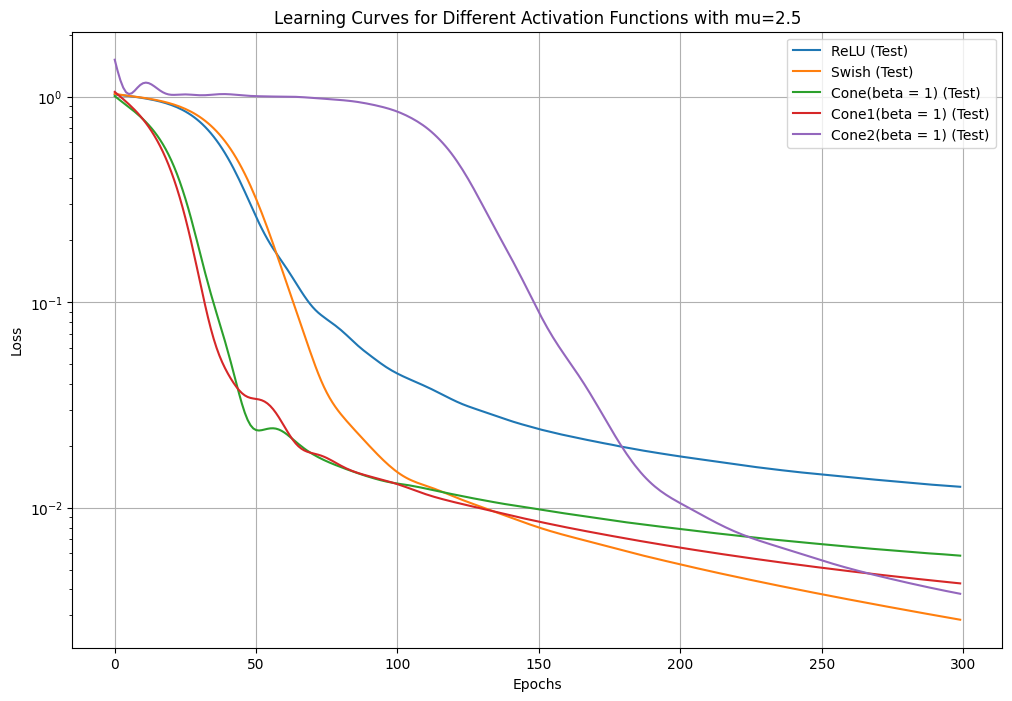

In [ ]:
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

class Cone2(nn.Module):
    def __init__(self, beta, mu):
        super(Cone2, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs2(1 - x, self.mu)**self.beta

mu=2.5
activation_functions = {
    "ReLU": nn.ReLU(),
    "Swish": Swish(),
    "Cone(beta = 1)": Cone(beta = 1),
    "Cone1(beta = 1)": Cone1(beta = 1, mu = mu),
    "Cone2(beta = 1)": Cone2(beta = 1, mu = mu),
}

num_epochs = 300
learning_rate = 0.001

train_losses_dict = {}
test_losses_dict = {}

for i, activation_name in enumerate(activation_functions.keys()):
    #print(f"Training model with {activation_name} activation...")
    train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot learning curves
plt.figure(figsize=(12, 8))

#for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
#    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with mu={}'.format(mu))
plt.legend()
plt.grid(True)
plt.show()

We observe that:
- For $\mu=2.5$, cone2 performs even worse than ReLU, while cone1 behaves similar to cone.
- For $\mu=1$, cone is better than both cone1, cone2.

It is interesting to see if a higher value of $\mu$ yield better test performance for cone1.

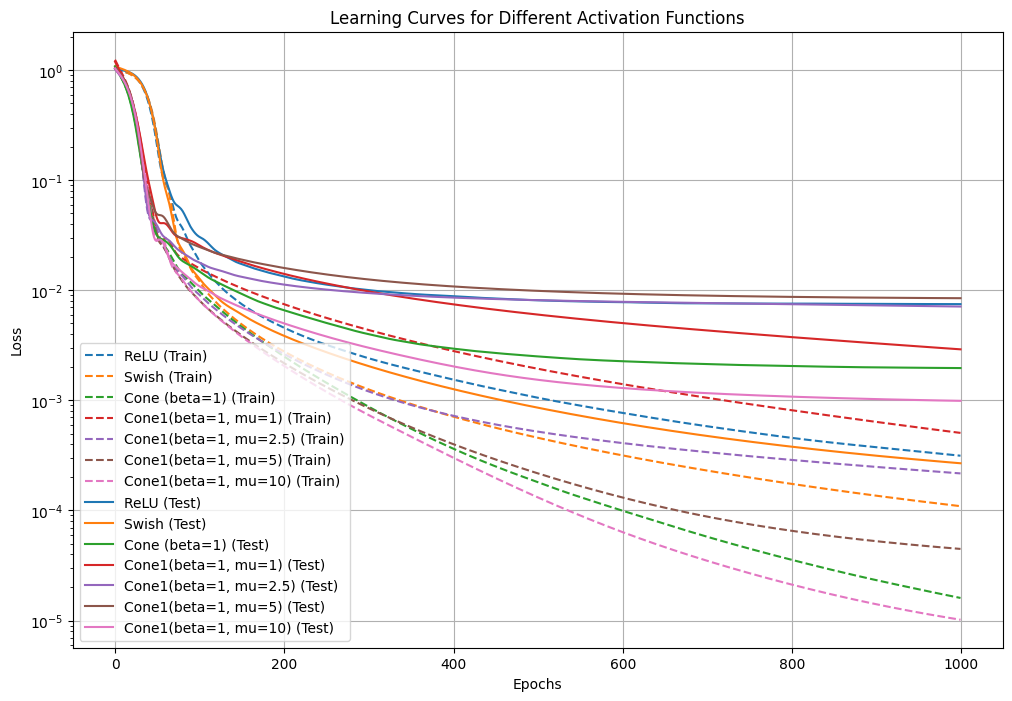

In [ ]:
# Define activation functions with different mu values for Cone1
mu_values = [1, 2.5, 5, 10]
activation_functions = {
    "ReLU": nn.ReLU(),
    "Swish": Swish(),
    "Cone (beta=1)": Cone(beta=1)
}

# Add Cone1 with different mu values
for mu in mu_values:
    activation_functions[f'Cone1(beta=1, mu={mu})'] = Cone1(beta=1, mu=mu)


num_epochs = 1000
learning_rate = 0.001

train_losses_dict = {}
test_losses_dict = {}

for i, activation_name in enumerate(activation_functions.keys()):
    #print(f"Training model with {activation_name} activation...")
    train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()

Swish still performs the best while it is not clear for the cones. Let us run several iterations.

In [ ]:
import pandas as pd
# Run 100 iterations for each activation function and collect results
results = {name: {'train': [], 'test': []} for name in activation_functions.keys()}

num_iterations = 100

for activation_name, activation_function in activation_functions.items():
    for _ in range(num_iterations):
        train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
        results[activation_name]['train'].append(train_losses[-1])
        results[activation_name]['test'].append(test_losses[-1])

# Calculate mean, std, and median for train and test errors
summary = []

for activation_name in results.keys():
    train_errors = results[activation_name]['train']
    test_errors = results[activation_name]['test']
    summary.append({
        'Activation Function': activation_name,
        'Train Mean': np.mean(train_errors),
        'Train Std': np.std(train_errors),
        'Train Median': np.median(train_errors),
        'Test Mean': np.mean(test_errors),
        'Test Std': np.std(test_errors),
        'Test Median': np.median(test_errors),
    })

# Convert summary to DataFrame and print
summary_df = pd.DataFrame(summary)
print(summary_df)
# summary_df.to_csv('activation_function_summary.csv', index=False)

     Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                   ReLU    0.000293   0.000053      0.000289   0.006158   
1                  Swish    0.000103   0.000015      0.000101   0.000318   
2          Cone (beta=1)    0.000012   0.000006      0.000011   0.002552   
3    Cone1(beta=1, mu=1)    0.000452   0.000107      0.000435   0.002762   
4  Cone1(beta=1, mu=2.5)    0.000205   0.000022      0.000202   0.003175   
5    Cone1(beta=1, mu=5)    0.000038   0.000006      0.000037   0.002814   
6   Cone1(beta=1, mu=10)    0.000013   0.000004      0.000013   0.002586   

   Test Std  Test Median  
0  0.001208     0.006116  
1  0.000078     0.000307  
2  0.001176     0.002369  
3  0.000755     0.002675  
4  0.001206     0.002959  
5  0.001589     0.002490  
6  0.001295     0.002457  


In [ ]:
import pandas as pd
# Convert summary to DataFrame and print
summary_df = pd.DataFrame(summary)
print(summary_df)
# summary_df.to_csv('activation_function_summary.csv', index=False)

     Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                   ReLU    0.000287   0.000046      0.000286   0.006158   
1                  Swish    0.000104   0.000019      0.000100   0.000309   
2          Cone (beta=1)    0.000012   0.000005      0.000011   0.002461   
3    Cone1(beta=1, mu=1)    0.000457   0.000106      0.000443   0.002872   
4  Cone1(beta=1, mu=2.5)    0.000208   0.000023      0.000205   0.003072   
5    Cone1(beta=1, mu=5)    0.000040   0.000006      0.000039   0.002686   
6   Cone1(beta=1, mu=10)    0.000012   0.000004      0.000012   0.002677   

   Test Std  Test Median  
0  0.001460     0.005954  
1  0.000085     0.000296  
2  0.001039     0.002217  
3  0.000811     0.002721  
4  0.001286     0.002922  
5  0.001143     0.002499  
6  0.001096     0.002485  


Hence, we can smoothening the cone does not help the optimization or the generalization a lot. Cone1(beta=1,mu=10) had slightly better median than Cone(beta=1).

The last thing we can try is to set the hyperparameters $\beta,\mu$ learnable.

In [ ]:
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos





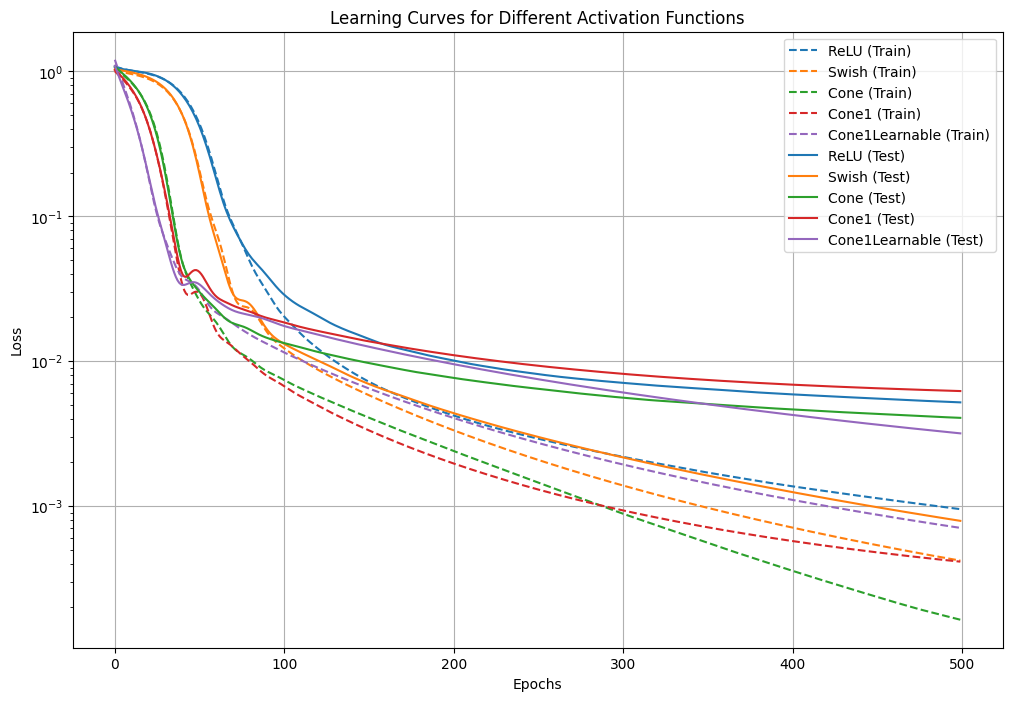

In [ ]:
num_epochs = 500
learning_rate = 0.001

activation_functions = {
            "ReLU": nn.ReLU(),
            "Swish": Swish(),
            "Cone": Cone(beta=1),
            "Cone1": Cone1(beta=1, mu=2.5),
            "Cone1Learnable": Cone1Learnable()
        }

train_losses_dict = {}
test_losses_dict = {}

for i, activation_name in enumerate(activation_functions.keys()):
    #print(f"Training model with {activation_name} activation...")
    train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
# Run 100 iterations for each activation function and collect results
results = {name: {'train': [], 'test': []} for name in activation_functions.keys()}

num_iterations = 100

for activation_name, activation_function in activation_functions.items():
    for _ in range(num_iterations):
        train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
        results[activation_name]['train'].append(train_losses[-1])
        results[activation_name]['test'].append(test_losses[-1])

# Calculate mean, std, and median for train and test errors
summary = []

for activation_name in results.keys():
    train_errors = results[activation_name]['train']
    test_errors = results[activation_name]['test']
    summary.append({
        'Activation Function': activation_name,
        'Train Mean': np.mean(train_errors),
        'Train Std': np.std(train_errors),
        'Train Median': np.median(train_errors),
        'Test Mean': np.mean(test_errors),
        'Test Std': np.std(test_errors),
        'Test Median': np.median(test_errors),
    })

# Convert summary to DataFrame and print
summary_df = pd.DataFrame(summary)
print(summary_df)
# summary_df.to_csv('activation_function_summary.csv', index=False)

  Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                ReLU    0.000984   0.000129      0.000974   0.007542   
1               Swish    0.000443   0.000078      0.000440   0.001045   
2                Cone    0.000186   0.000053      0.000183   0.003342   
3               Cone1    0.000458   0.000052      0.000454   0.003862   
4      Cone1Learnable    0.000432   0.000069      0.000422   0.003172   

   Test Std  Test Median  
0  0.001593     0.007293  
1  0.000246     0.001016  
2  0.001272     0.003180  
3  0.001270     0.003675  
4  0.001131     0.002958  


Understandably, Cone1Learnable performs better than Cone and Cone1, but still incomparable to Siwsh. We need to look for a better activation function.

# 3. Mixing Swish and Cone

From previous experiments, no modifications of Cone can perform even comparably to Swish's. In this section, instead of modifying the Cone or creating a new activation function (AF), we try to mix Swish and Cone activation functions in an MLP and see if the training speed and test performance are improved.

To this end, we can mix the two AF in two ways: inter-layer mixing and intra-layer mixing.

1. Inter-layer mixing: instead of an MLP with only one AF, we apply different an AF on each layer. For example, for a 4-hidden-layer MLP, we denote S4 = SSSS the MLP with pure Swish and C4 = CCCC that with pure Cone. The architecture/configuration CSSS indicates that Cone is applied on the first hidden-layer and Swish on the last three layers. Other architectures like CCSS, SCCC, SCCS,... are defined similarly.
2. Intra-layer mixing: given an integer $L$ and an L-tuple $\mathbf{r}=(r_1,...,r_L)$ of positive numbers $r_l\in[0,1]$, in layer $l=1,...,L$, a portion of $r_1$ neurons are applied by Cone and the rest by Swish. For example, if $\mathbf{r}=0.5\cdot\mathbf{1}_L$, the MLP is simply combining a Swish- and a Cone-MLP with half the width. Note that, with this notation, Inter-layer mixing is a special case of INtra-layer mixing. For instance, $(0,1,1,1)$ indicates the architecture SCCC.

## 3.1 Inter-layer mixing

We begin our experiment with Inter-layer mixing.

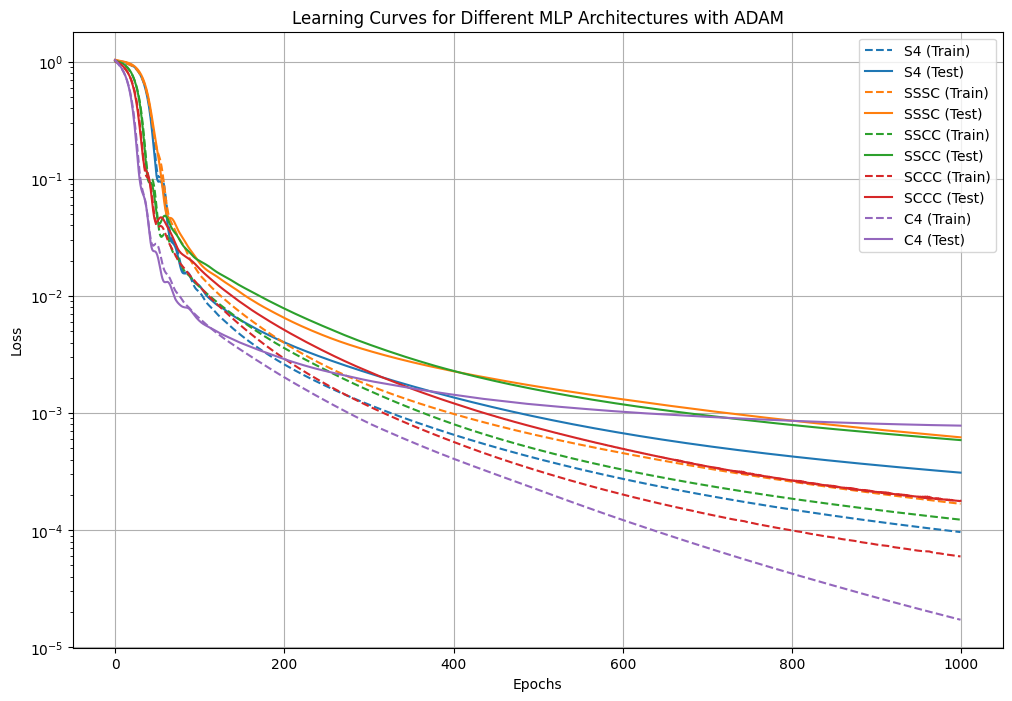

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf
import pandas as pd
import matplotlib.colors as mcolors

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone activation function
class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model with different activations for each layer
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activations):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.activations.append(activations[0])

        for i in range(1, len(activations)):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.activations.append(activations[i])

        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer, activation in zip(self.layers[:-1], self.activations):
            x = activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and Adam optimizer
def train_model(model, train_loader, test_loader, num_epochs=500, learning_rate=0.001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)  # Move the model to the device
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 1000
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 4
num_epochs = 1000
learning_rate = 0.001

# Define architectures
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "SSSC": [Swish(), Swish(), Swish(), Cone(beta=1)],
    "SSCC": [Swish(), Swish(), Cone(beta=1), Cone(beta=1)],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "C4": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Cone(beta=1)]
}

# Train and evaluate each architecture
results = {arch_name: {"train_losses": [], "test_losses": []} for arch_name in architectures.keys()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for arch_name, activations in architectures.items():
    model = MLP(input_dim, hidden_dim, output_dim, activations)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device=device)
    results[arch_name]["train_losses"] = train_losses
    results[arch_name]["test_losses"] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the results
plt.figure(figsize=(12, 8))

for i, (arch_name, losses) in enumerate(results.items()):
    plt.plot(losses["train_losses"], label=f"{arch_name} (Train)", color=colors[i], linestyle='dashed')
    plt.plot(losses["test_losses"], label=f"{arch_name} (Test)", color=colors[i], linestyle='solid')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different MLP Architectures with ADAM')
plt.legend()
plt.grid(True)
plt.show()


We have the following observations:
1. This time, the best architecture is SCCC, not SSSS=S4!
2. S4 is the second best, while the others (C4,SSSC, SSCC) are comparable to each other.
3. Taking training speed into account, SCCC also yield a faster learning curve than S4.

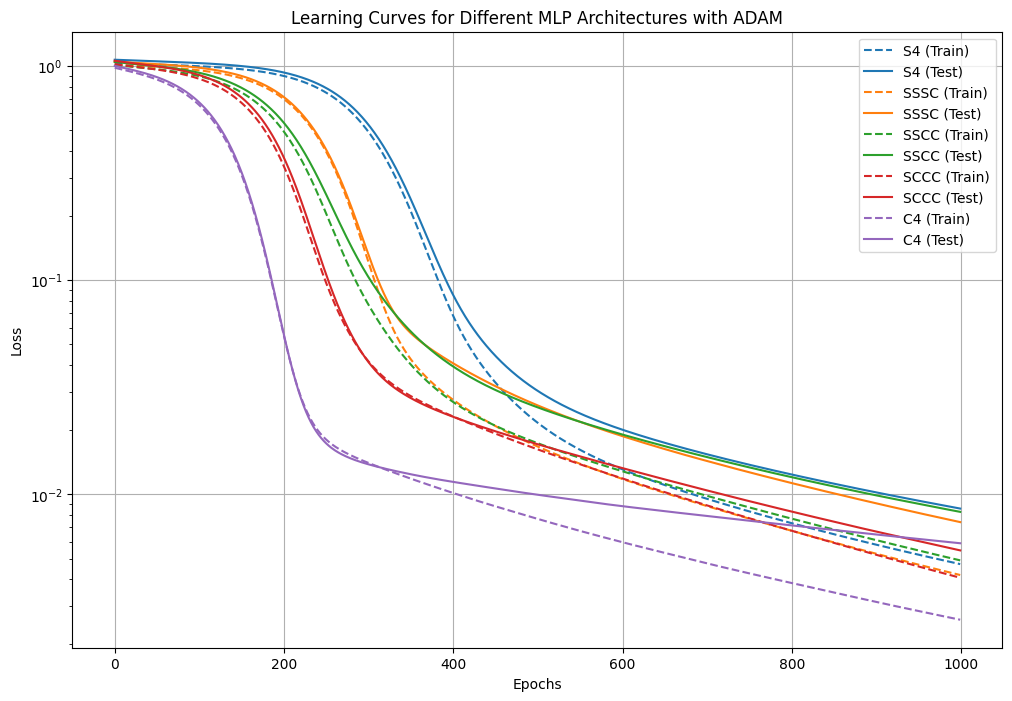

In [ ]:
# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 4
num_epochs = 1000
learning_rate = 0.0001

# Define architectures
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "SSSC": [Swish(), Swish(), Swish(), Cone(beta=1)],
    "SSCC": [Swish(), Swish(), Cone(beta=1), Cone(beta=1)],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "C4": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Cone(beta=1)]
}

# Train and evaluate each architecture
results = {arch_name: {"train_losses": [], "test_losses": []} for arch_name in architectures.keys()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for arch_name, activations in architectures.items():
    model = MLP(input_dim, hidden_dim, output_dim, activations)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device=device)
    results[arch_name]["train_losses"] = train_losses
    results[arch_name]["test_losses"] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the results
plt.figure(figsize=(12, 8))

for i, (arch_name, losses) in enumerate(results.items()):
    plt.plot(losses["train_losses"], label=f"{arch_name} (Train)", color=colors[i], linestyle='dashed')
    plt.plot(losses["test_losses"], label=f"{arch_name} (Test)", color=colors[i], linestyle='solid')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different MLP Architectures with ADAM')
plt.legend()
plt.grid(True)
plt.show()

With a slower learning rate on ADAM, we can see that SCCC learns faster than S4.

From a few experimental run, it seems SCC's test performance is the best. Let us run some more iterations and check the mean and median.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf
import pandas as pd

# Define Cone activation function
class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model with different activations for each layer
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activations):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.activations.append(activations[0])

        for i in range(1, len(activations)):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.activations.append(activations[i])

        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer, activation in zip(self.layers[:-1], self.activations):
            x = activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and Adam optimizer
def train_model(model, train_loader, test_loader, num_epochs=500, learning_rate=0.001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)  # Move the model to the device
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

def evaluate_architecture(hidden_dim, num_layers, architecture, num_epochs, learning_rate, num_iterations):
    # Generate synthetic regression dataset
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoaders
    batch_size = 1000
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define activation functions
    activations = {
        "Swish": Swish(),
        "Cone(beta=1)": Cone(beta=1)
    }

    results = {arch: {"train_errors": [], "test_errors": []} for arch in architecture}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for _ in range(num_iterations):
        for arch_name, arch_layers in architecture.items():
            model = MLP(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=1, activations=arch_layers)
            train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device=device)
            results[arch_name]["train_errors"].append(train_losses[-1])
            results[arch_name]["test_errors"].append(test_losses[-1])

    # Compute mean, std, and median for each architecture
    statistics = {"Architecture": [], "Train Mean": [], "Train Std": [], "Train Median": [], "Test Mean": [], "Test Std": [], "Test Median": []}

    for arch_name, errors in results.items():
        train_errors = np.array(errors["train_errors"])
        test_errors = np.array(errors["test_errors"])

        statistics["Architecture"].append(arch_name)
        statistics["Train Mean"].append(np.mean(train_errors))
        statistics["Train Std"].append(np.std(train_errors))
        statistics["Train Median"].append(np.median(train_errors))
        statistics["Test Mean"].append(np.mean(test_errors))
        statistics["Test Std"].append(np.std(test_errors))
        statistics["Test Median"].append(np.median(test_errors))

    df_statistics = pd.DataFrame(statistics)
    return df_statistics


In [ ]:
# Define architectures
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "C4": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "SSSC": [Swish(), Swish(), Swish(), Cone(beta=1)],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "CSSS": [Cone(beta=1), Swish(), Swish(), Swish()],
    "CCCS": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Swish()],
    "SCCS": [Swish(), Cone(beta=1), Cone(beta=1), Swish()],
    "CSSC": [Cone(beta=1), Swish(), Swish(), Cone(beta=1)]
}

# Run the function with example parameters
hidden_dim = 16
num_layers = 4
num_epochs = 500
learning_rate = 0.001
num_iterations = 5

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

  Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0           S4    0.000781   0.000086      0.000791   0.001343  0.000191   
1           C4    0.000104   0.000055      0.000093   0.002479  0.000825   
2         SSSC    0.000745   0.000152      0.000762   0.001495  0.000362   
3         SCCC    0.000759   0.000086      0.000752   0.001773  0.000287   
4         CSSS    0.000283   0.000090      0.000276   0.003319  0.001613   
5         CCCS    0.000180   0.000035      0.000190   0.004664  0.001911   
6         SCCS    0.000733   0.000124      0.000671   0.001886  0.000731   
7         CSSC    0.000381   0.000126      0.000329   0.003335  0.000947   

   Test Median  
0     0.001316  
1     0.002563  
2     0.001313  
3     0.001670  
4     0.003636  
5     0.004295  
6     0.001708  
7     0.003238  


In [ ]:
# Define architectures
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "C4": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "SSSC": [Swish(), Swish(), Swish(), Cone(beta=1)],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "CSSS": [Cone(beta=1), Swish(), Swish(), Swish()],
    "CCCS": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Swish()],
    "SCCS": [Swish(), Cone(beta=1), Cone(beta=1), Swish()],
    "CSSC": [Cone(beta=1), Swish(), Swish(), Cone(beta=1)]
}

# Run the function with example parameters
hidden_dim = 16
num_layers = 4
num_epochs = 1000
learning_rate = 0.001
num_iterations = 10

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

  Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0           S4    0.000190   0.000038      0.000183   0.000441  0.000129   
1           C4    0.000004   0.000002      0.000004   0.002493  0.001265   
2         SSSC    0.000185   0.000030      0.000185   0.000442  0.000128   
3         SCCC    0.000121   0.000036      0.000106   0.000428  0.000202   
4         CSSS    0.000087   0.000020      0.000087   0.002324  0.000820   
5         CCCS    0.000044   0.000026      0.000034   0.002194  0.001559   
6         SCCS    0.000155   0.000039      0.000160   0.000459  0.000113   
7         CSSC    0.000072   0.000015      0.000070   0.001644  0.000740   

   Test Median  
0     0.000418  
1     0.002816  
2     0.000422  
3     0.000382  
4     0.002077  
5     0.001955  
6     0.000480  
7     0.001571  


For L = 3 or 4, we can see the architecture SCC and SCCC perform the best. The intuition behind is perhaps the Swish layer can capture the features well and the Cone can transmit the alignment well to the rest of the network. Also, the convergence rate is faster than pure Swish S4. Let us run more iterations to ensure the improvement.

In [ ]:
# Define architectures
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "C4": [Cone(beta=1), Cone(beta=1), Cone(beta=1), Cone(beta=1)]
}

# Run the function with example parameters
hidden_dim = 16
num_layers = 4
num_epochs = 1000
learning_rate = 0.001
num_iterations = 100

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

  Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0           S4    0.000177   0.000049      0.000173   0.000394  0.000121   
1         SCCC    0.000128   0.000046      0.000119   0.000390  0.000169   
2           C4    0.000005   0.000003      0.000004   0.002595  0.001594   

   Test Median  
0     0.000367  
1     0.000341  
2     0.002176  


Before ending this subsection, let us test the architecture SCCC with the variants of Cone.

In [ ]:
# Define the variants of Cone

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(np.log(np.exp(1)-1)))
        self.mu = nn.Parameter(torch.tensor(np.log(np.exp(2.5)-1)))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos


# Define architectures, S = Swish, C = Cone(beta=1), M = Cone1(beta=1, mu=10), N = Cone1(beta=1, mu=2.5), L = Cone1Learnable()
architectures = {
    "S4": [Swish(), Swish(), Swish(), Swish()],
    "SCCC": [Swish(), Cone(beta=1), Cone(beta=1), Cone(beta=1)],
    "SMMM": [Swish(), Cone1(beta=1, mu=10), Cone1(beta=1, mu=10), Cone1(beta=1, mu=10)],
    "SNNN": [Swish(), Cone1(beta=1, mu=2.5), Cone1(beta=1, mu=2.5), Cone1(beta=1, mu=2.5)],
    "SLLL": [Swish(), Cone1Learnable(), Cone1Learnable(), Cone1Learnable()]
}

# Run the function with example parameters
hidden_dim = 16
num_layers = 4
num_epochs = 1000
learning_rate = 0.001
num_iterations = 100

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

  Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0           S4    0.000181   0.000043      0.000174   0.000413  0.000134   
1         SCCC    0.000125   0.000050      0.000119   0.000403  0.000245   
2         SMMM    0.000125   0.000049      0.000117   0.000363  0.000163   
3         SNNN    0.000189   0.000062      0.000174   0.000482  0.000157   
4         SLLL    0.000240   0.000078      0.000228   0.000655  0.000248   

   Test Median  
0     0.000393  
1     0.000346  
2     0.000313  
3     0.000434  
4     0.000609  


Nice. The architecture SMMM performs excellent! Also, due to the smoothened cone head, the standard deiviation of the test error is significantly dropped. Also, a large mu (mu=10) yields a better performance than a small one (mu=2.5).

## 3.2 Intra-layer mixing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf
import pandas as pd

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone activation function
class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the Composite Activation function
class CompositeActivation(nn.Module):
    def __init__(self, activation1, activation2):
        super(CompositeActivation, self).__init__()
        self.activation1 = activation1
        self.activation2 = activation2

    def forward(self, x):
        half_size = x.size(1) // 2
        x1 = self.activation1(x[:, :half_size])
        x2 = self.activation2(x[:, half_size:])
        return torch.cat((x1, x2), dim=1)

# Define the MLP model with composite activation function
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and Adam optimizer
def train_model(model, train_loader, test_loader, num_epochs=500, learning_rate=0.001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)  # Move the model to the device
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

def evaluate_architecture(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations):
    # Generate synthetic regression dataset
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Define activation functions
    swish = Swish()
    cone = Cone(beta=1)
    composite_activation = CompositeActivation(swish, cone)

    architectures = {
        "S3": swish,
        "C3": cone,
        "Composite": composite_activation
    }

    results = {arch: {"train_errors": [], "test_errors": []} for arch in architectures.keys()}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for _ in range(num_iterations):
        for arch_name, activation_function in architectures.items():
            model = MLP(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers, activation_function=activation_function)
            train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device=device)
            results[arch_name]["train_errors"].append(train_losses[-1])
            results[arch_name]["test_errors"].append(test_losses[-1])

    # Compute mean, std, and median for each architecture
    statistics = {"Architecture": [], "Train Mean": [], "Train Std": [], "Train Median": [], "Test Mean": [], "Test Std": [], "Test Median": []}

    for arch_name, errors in results.items():
        train_errors = np.array(errors["train_errors"])
        test_errors = np.array(errors["test_errors"])

        statistics["Architecture"].append(arch_name)
        statistics["Train Mean"].append(np.mean(train_errors))
        statistics["Train Std"].append(np.std(train_errors))
        statistics["Train Median"].append(np.median(train_errors))
        statistics["Test Mean"].append(np.mean(test_errors))
        statistics["Test Std"].append(np.std(test_errors))
        statistics["Test Median"].append(np.median(test_errors))

    df_statistics = pd.DataFrame(statistics)
    return df_statistics




In [ ]:
# Run the function with example parameters
hidden_dim = 16
num_layers = 3
num_epochs = 1000
learning_rate = 0.001
num_iterations = 10

df_statistics = evaluate_architecture(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations)
print(df_statistics)

  Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0           S3    0.000026   0.000029      0.000015   0.000026  0.000021   
1           C3    0.000027   0.000032      0.000015   0.001946  0.000780   
2    Composite    0.000021   0.000020      0.000012   0.000734  0.000424   

   Test Median  
0     0.000016  
1     0.001965  
2     0.000852  


Now let us investigate more on different tuples $(r_1,r_2,...,r_L)$.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf
import pandas as pd

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone activation function
class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the Composite Activation function
class CompositeActivation(nn.Module):
    def __init__(self, activation1, activation2, ratio):
        super(CompositeActivation, self).__init__()
        self.activation1 = activation1
        self.activation2 = activation2
        self.ratio = ratio

    def forward(self, x):
        size = x.size(1)
        split_idx = int(size * self.ratio)
        x1 = self.activation1(x[:, :split_idx])
        x2 = self.activation2(x[:, split_idx:])
        return torch.cat((x1, x2), dim=1)

# Define the MLP model with composite activation function
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_list):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(len(activation_list) - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation_list = activation_list

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_list[i](layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and Adam optimizer
def train_model(model, train_loader, test_loader, num_epochs=500, learning_rate=0.001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)  # Move the model to the device
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the device
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

# Define the function to generate the architecture list
def tuple2archi(num_layers, ratio_tuple):
    activation_list = []
    swish = Swish()
    cone = Cone(beta=1)
    for ratio in ratio_tuple:
        activation_list.append(CompositeActivation(cone, swish, ratio))
    return activation_list

# Define the function to create architecture dictionary from tuples
def tuple2dict(num_layers, tuples):
    architectures = {}
    for ratio_tuple in tuples:
        arch_name = str(ratio_tuple)
        architectures[arch_name] = tuple2archi(num_layers, ratio_tuple)
    return architectures

# Define the evaluation function
def evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations):
    # Generate synthetic regression dataset
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    results = {arch: {"train_errors": [], "test_errors": []} for arch in architectures.keys()}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for _ in range(num_iterations):
        for arch_name, activation_list in architectures.items():
            model = MLP(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=1, activation_list=activation_list)
            train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device=device)
            results[arch_name]["train_errors"].append(train_losses[-1])
            results[arch_name]["test_errors"].append(test_losses[-1])

    # Compute mean, std, and median for each architecture
    statistics = {"Architecture": [], "Train Mean": [], "Train Std": [], "Train Median": [], "Test Mean": [], "Test Std": [], "Test Median": []}

    for arch_name, errors in results.items():
        train_errors = np.array(errors["train_errors"])
        test_errors = np.array(errors["test_errors"])

        statistics["Architecture"].append(arch_name)
        statistics["Train Mean"].append(np.mean(train_errors))
        statistics["Train Std"].append(np.std(train_errors))
        statistics["Train Median"].append(np.median(train_errors))
        statistics["Test Mean"].append(np.mean(test_errors))
        statistics["Test Std"].append(np.std(test_errors))
        statistics["Test Median"].append(np.median(test_errors))

    df_statistics = pd.DataFrame(statistics)
    return df_statistics

In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 1000
learning_rate = 0.001
num_iterations = 100

# Define tuples for different architectures
tuples = [
    (0, 0, 0),
    (1, 0, 0),
    (0, 1, 1),
    (1, 1, 1)
]

# Generate architecture dictionary from tuples
architectures = tuple2dict(num_layers, tuples)

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

Let us consider the learning curves from the interpolation between the tuple (0,0,0) and (1,1,1).

In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 100
learning_rate = 0.001
num_iterations = 5

# Define tuples for different architectures
tuples_list = [(i/10, i/10, i/10) for i in range(11)]

# Generate architecture dictionary from tuples
architectures = tuple2dict(num_layers, tuples_list)

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

       Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0   (0.0, 0.0, 0.0)    0.000002   0.000001      0.000002   0.001894  0.000897   
1   (0.1, 0.1, 0.1)    0.000015   0.000007      0.000014   0.002344  0.001148   
2   (0.2, 0.2, 0.2)    0.000023   0.000005      0.000022   0.002242  0.001011   
3   (0.3, 0.3, 0.3)    0.000037   0.000007      0.000034   0.001480  0.000574   
4   (0.4, 0.4, 0.4)    0.000046   0.000008      0.000044   0.001109  0.000708   
5   (0.5, 0.5, 0.5)    0.000059   0.000022      0.000058   0.001633  0.000445   
6   (0.6, 0.6, 0.6)    0.000060   0.000009      0.000064   0.001444  0.000890   
7   (0.7, 0.7, 0.7)    0.000067   0.000017      0.000055   0.000887  0.000608   
8   (0.8, 0.8, 0.8)    0.000065   0.000017      0.000076   0.000778  0.000407   
9   (0.9, 0.9, 0.9)    0.000083   0.000008      0.000082   0.000808  0.000574   
10  (1.0, 1.0, 1.0)    0.000083   0.000011      0.000081   0.000158  0.000025   

    Test Median  
0      0.

In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 1000
learning_rate = 0.001
num_iterations = 10

# Define tuples for different architectures
tuples_list = [(i/10, i/10, i/10) for i in range(11)]

# Generate architecture dictionary from tuples
architectures = tuple2dict(num_layers, tuples_list)

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

       Architecture  Train Mean  Train Std  Train Median  Test Mean  Test Std  \
0   (0.0, 0.0, 0.0)    0.000021   0.000029      0.000009   0.002001  0.001193   
1   (0.1, 0.1, 0.1)    0.000024   0.000022      0.000016   0.001556  0.000802   
2   (0.2, 0.2, 0.2)    0.000015   0.000013      0.000009   0.001840  0.000902   
3   (0.3, 0.3, 0.3)    0.000010   0.000014      0.000005   0.001932  0.000769   
4   (0.4, 0.4, 0.4)    0.000019   0.000017      0.000012   0.001227  0.000499   
5   (0.5, 0.5, 0.5)    0.000046   0.000050      0.000036   0.000791  0.000500   
6   (0.6, 0.6, 0.6)    0.000020   0.000015      0.000015   0.000767  0.000476   
7   (0.7, 0.7, 0.7)    0.000032   0.000030      0.000019   0.000829  0.000556   
8   (0.8, 0.8, 0.8)    0.000016   0.000015      0.000008   0.000353  0.000237   
9   (0.9, 0.9, 0.9)    0.000018   0.000017      0.000010   0.000145  0.000120   
10  (1.0, 1.0, 1.0)    0.000019   0.000021      0.000013   0.000015  0.000014   

    Test Median  
0      0.

In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 1000
learning_rate = 0.001
num_iterations = 10

# Define tuples for different architectures
tuples_list = [(1, i/10, i/10) for i in range(11)]

# Generate architecture dictionary from tuples
architectures = tuple2dict(num_layers, tuples_list)

df_statistics = evaluate_architecture(hidden_dim, num_layers, architectures, num_epochs, learning_rate, num_iterations)
print(df_statistics)

# ?. Small step minibatch ADAM

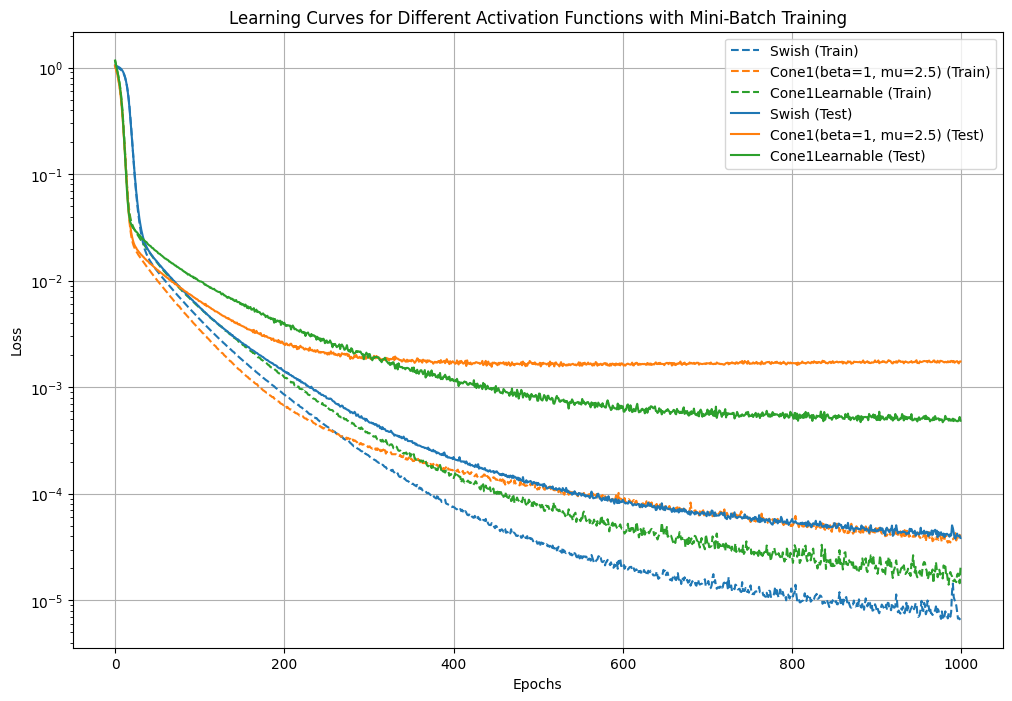

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf

class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Learnable Cone1
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

# Define Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3
num_epochs = 1000
learning_rate = 0.0001 # smaller learning rate, as in paper [1]

# Define activation functions
activation_functions = {
    "Swish": Swish(),
    "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
    "Cone1Learnable": Cone1Learnable(),
}

# Train and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with Mini-Batch Training')
plt.legend()
plt.grid(True)
plt.show()


# ?. Other Optimizers

In [ ]:
!pip install torchsampler


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsampler import SAM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Learnable Cone1
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

# Define ReLU(Cone1(beta=1, mu=2.5))
class ReLU_Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(ReLU_Cone1, self).__init__()
        self.cone1 = Cone1(beta, mu)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.cone1(x))

# Define Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    base_optimizer = optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.first_step(zero_grad=True)
            criterion(model(X_batch), y_batch).backward()
            optimizer.second_step(zero_grad=True)
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 3
num_epochs = 1000
learning_rate = 0.001

# Define activation functions
activation_functions = {
    "Swish": Swish(),
    "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
    "Cone1Learnable": Cone1Learnable()
}

# Train and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with SAM Optimizer')
plt.legend()
plt.grid


ImportError: cannot import name 'SAM' from 'torchsampler' (/usr/local/lib/python3.10/dist-packages/torchsampler/__init__.py)

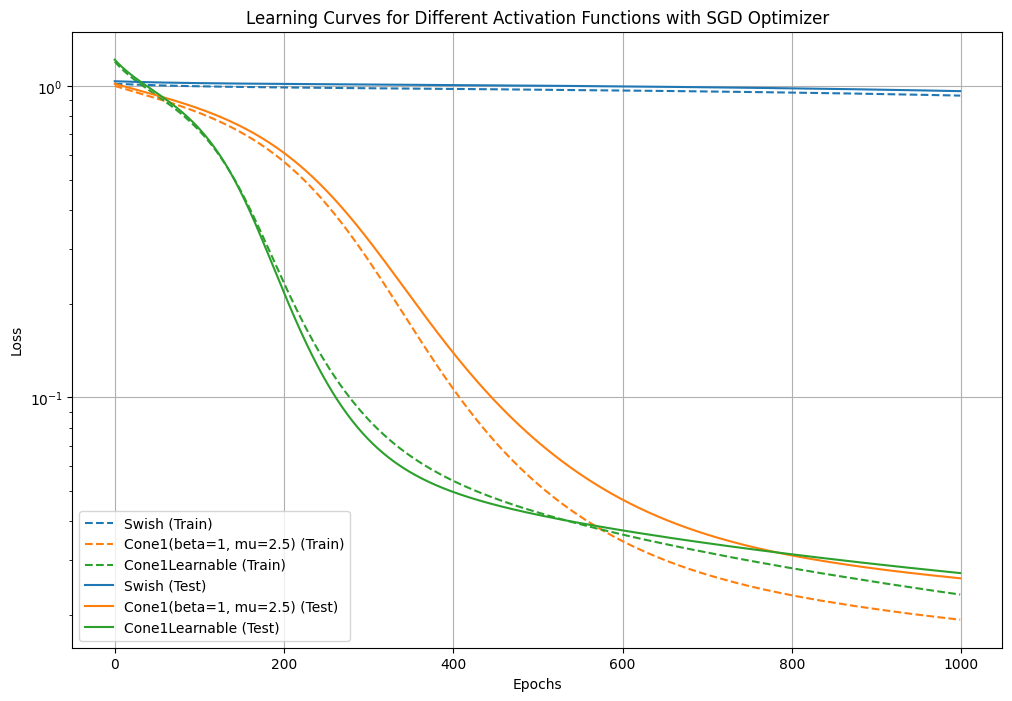

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import erf

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Learnable Cone1
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

# Define ReLU(Cone1(beta=1, mu=2.5))
class ReLU_Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(ReLU_Cone1, self).__init__()
        self.cone1 = Cone1(beta, mu)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.cone1(x))

# Define Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and SGD optimizer
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3
num_epochs = 1000
learning_rate = 0.0001

# Define activation functions
activation_functions = {
    "Swish": Swish(),
    "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
    "Cone1Learnable": Cone1Learnable(),
    #"ReLU(Cone1(beta=1, mu=2.5))": ReLU_Cone1(beta=1, mu=2.5)
}

# Train and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with SGD Optimizer')
plt.legend()
plt.grid(True)
plt.show()


For SGD with small learning rate, it seems Cone can still behave reasonably.

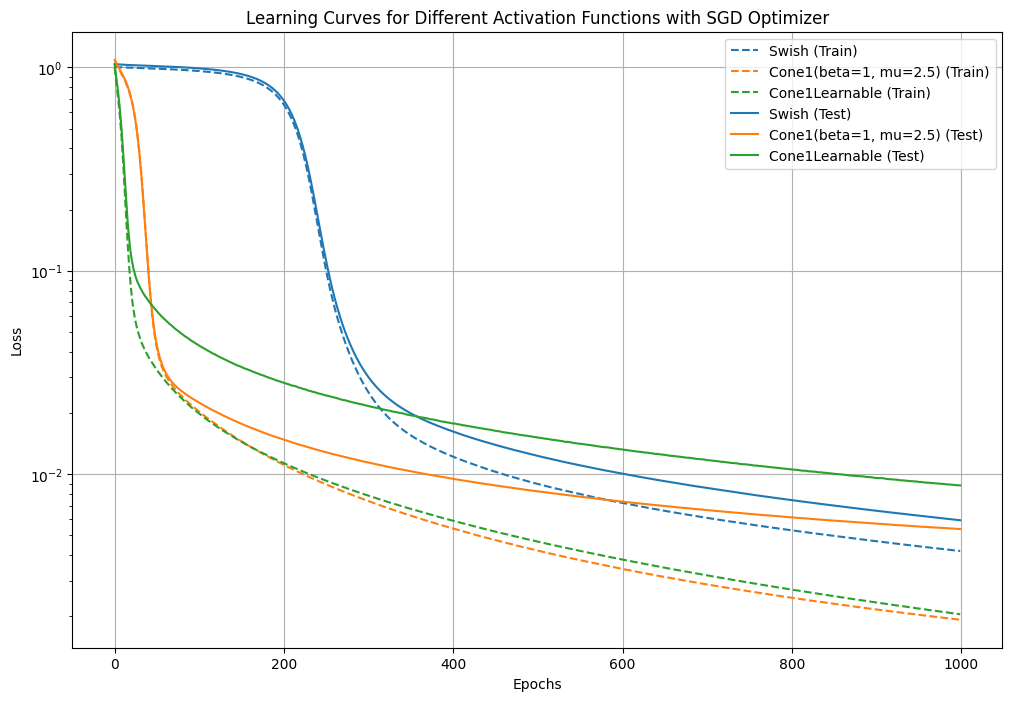

In [ ]:
# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3
num_epochs = 1000
learning_rate = 0.0001

# Define activation functions
activation_functions = {
    "Swish": Swish(),
    "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
    "Cone1Learnable": Cone1Learnable()
}


# Train and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with SGD Optimizer')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import erf
import pandas as pd

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone
class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta


# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Learnable Cone1
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(np.log(np.e - 1), dtype=torch.float32))
        self.mu = nn.Parameter(torch.tensor(np.log(np.e**2.5 - 1), dtype=torch.float32))


    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

# Define Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function with mini-batch training and Adam optimizer
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_losses.append(test_loss / len(test_loader.dataset))

    return train_losses, test_losses

def experiment(hidden_dim, num_layers, num_epochs, learning_rate=0.001, num_iterations=100, device='cpu'):
    # Generate synthetic regression dataset
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define activation functions
    activation_functions = {
        "Swish": Swish(),
        "Cone(beta=1)": Cone(beta=1),
        "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
        "Cone1Learnable": Cone1Learnable()
    }

    # Run multiple iterations and collect final train and test errors
    results = {activation_name: {"train_errors": [], "test_errors": []} for activation_name in activation_functions.keys()}

    for _ in range(num_iterations):
        for activation_name, activation_function in activation_functions.items():
            model = MLP(X_train.shape[1], hidden_dim, 1, num_layers, activation_function).to(device)
            train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, learning_rate, device)

            results[activation_name]["train_errors"].append(train_losses[-1])
            results[activation_name]["test_errors"].append(test_losses[-1])

    # Compute mean, std, and median for each activation function
    statistics = {"Activation Function": [], "Train Mean": [], "Train Std": [], "Train Median": [], "Test Mean": [], "Test Std": [], "Test Median": []}

    for activation_name, errors in results.items():
        train_errors = np.array(errors["train_errors"])
        test_errors = np.array(errors["test_errors"])

        statistics["Activation Function"].append(activation_name)
        statistics["Train Mean"].append(np.mean(train_errors))
        statistics["Train Std"].append(np.std(train_errors))
        statistics["Train Median"].append(np.median(train_errors))
        statistics["Test Mean"].append(np.mean(test_errors))
        statistics["Test Std"].append(np.std(test_errors))
        statistics["Test Median"].append(np.median(test_errors))

    # Convert statistics to a DataFrame for easy viewing
    df_statistics = pd.DataFrame(statistics)
    return df_statistics



In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 100
learning_rate = 0.0001
num_iterations = 10

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_statistics = experiment(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations, device)
print(df_statistics)

     Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                  Swish    0.007361   0.001157      0.007173   0.009745   
1           Cone(beta=1)    0.005704   0.001176      0.005485   0.012375   
2  Cone1(beta=1, mu=2.5)    0.005403   0.000559      0.005361   0.008591   
3         Cone1Learnable    0.007247   0.001674      0.007077   0.012478   

   Test Std  Test Median  
0  0.002730     0.008999  
1  0.004736     0.011799  
2  0.001984     0.008161  
3  0.003447     0.012129  


In [ ]:
# Example usage
hidden_dim = 16
num_layers = 3
num_epochs = 200
learning_rate = 0.0001
num_iterations = 10

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_statistics = experiment(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations, device)
print(df_statistics)

     Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                  Swish    0.001466   0.000239      0.001427   0.002303   
1           Cone(beta=1)    0.000540   0.000154      0.000480   0.003193   
2  Cone1(beta=1, mu=2.5)    0.001184   0.000142      0.001179   0.003960   
3         Cone1Learnable    0.000979   0.000252      0.000894   0.003348   

   Test Std  Test Median  
0  0.000571     0.002215  
1  0.001162     0.003056  
2  0.001649     0.003403  
3  0.001741     0.002794  


In [ ]:
# Example usage
hidden_dim = 16
num_layers = 4
num_epochs = 200
learning_rate = 0.0001
num_iterations = 10

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_statistics = experiment(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations, device)
print(df_statistics)

     Activation Function  Train Mean  Train Std  Train Median  Test Mean  \
0                  Swish    0.001161   0.000195      0.001103   0.001793   
1           Cone(beta=1)    0.000410   0.000099      0.000364   0.002942   
2  Cone1(beta=1, mu=2.5)    0.001244   0.000222      0.001241   0.004671   
3         Cone1Learnable    0.000949   0.000190      0.000905   0.004235   

   Test Std  Test Median  
0  0.000547     0.001549  
1  0.000966     0.003258  
2  0.001452     0.004383  
3  0.001430     0.003690  


In [ ]:
# Example usage
hidden_dim = 16
num_layers = 8
num_epochs = 400
learning_rate = 0.0001
num_iterations = 10

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_statistics = experiment(hidden_dim, num_layers, num_epochs, learning_rate, num_iterations, device)
print(df_statistics)

     Activation Function  Train Mean     Train Std  Train Median  Test Mean  \
0                  Swish    0.000105  3.429149e-05      0.000102   0.000218   
1           Cone(beta=1)    0.000001  6.275683e-07      0.000001   0.002799   
2  Cone1(beta=1, mu=2.5)    0.000282  4.203442e-05      0.000273   0.002624   
3         Cone1Learnable    0.000160  2.076817e-05      0.000152   0.001886   

   Test Std  Test Median  
0  0.000074     0.000207  
1  0.001555     0.002590  
2  0.001378     0.002370  
3  0.001143     0.001446  


# ?. Swone

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone function
class Cone(nn.Module):
    def __init__(self, beta=1):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - abs(1 - x)**self.beta

# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Swish function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define Swicone function
class Swicone(nn.Module):
    def __init__(self):
        super(Swicone, self).__init__()
        self.cone = Cone(beta=1)
        self.swish = Swish()

    def forward(self, x):
        cone_part = self.cone(F.relu(x))
        swish_part = self.swish(-F.relu(-x))
        return cone_part + swish_part

# Example usage
# Assume input tensor t
t = torch.tensor([-1.0, 0.0, 1.0, 2.0])
activation = Swicone()
output = activation(t)
print(output)



tensor([-0.2689,  0.0000,  1.0000,  0.0000])


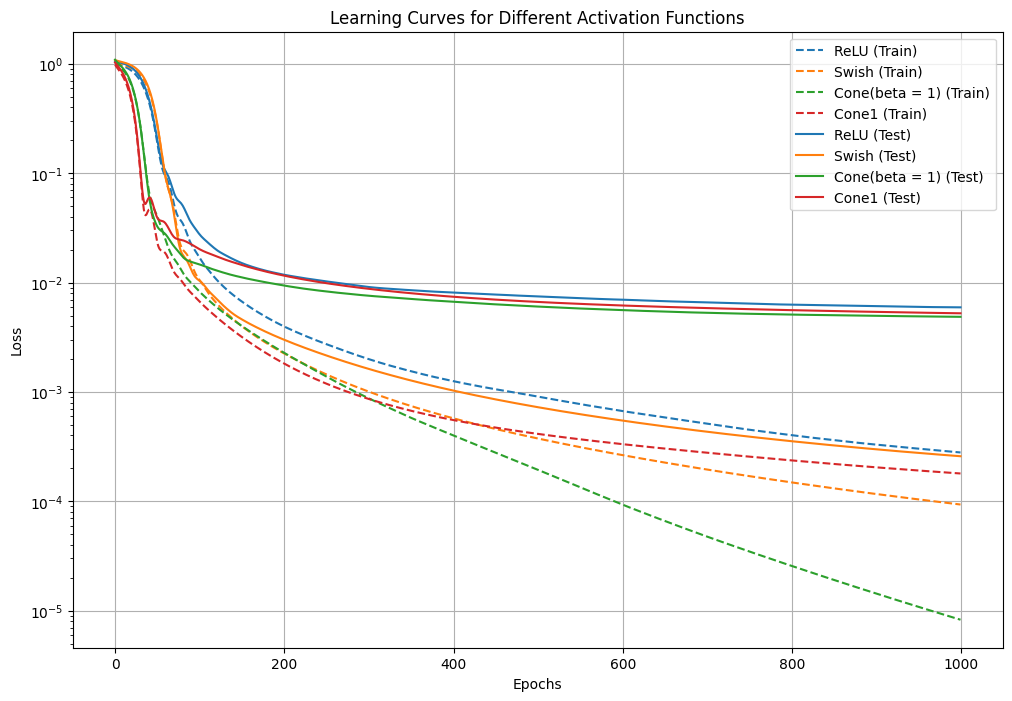

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


activation_functions = {
    "ReLU": nn.ReLU(),
    "Swish": Swish(),
    "Cone(beta = 1)": Cone(beta = 1),
    "Cone1": Cone1(beta=1, mu=2.5),
    #"Swicone": Swicone()
}

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3

# Training function
def train_model(activation_name, num_epochs=100, learning_rate=0.001):
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_functions[activation_name]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test).squeeze()
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        #print(f"Activation: {activation_name}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses

num_epochs = 1000
learning_rate = 0.001

train_losses_dict = {}
test_losses_dict = {}

for i, activation_name in enumerate(activation_functions.keys()):
    #print(f"Training model with {activation_name} activation...")
    train_losses, test_losses = train_model(activation_name, num_epochs, learning_rate)
    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()

# ?. Quadratic Neural Network

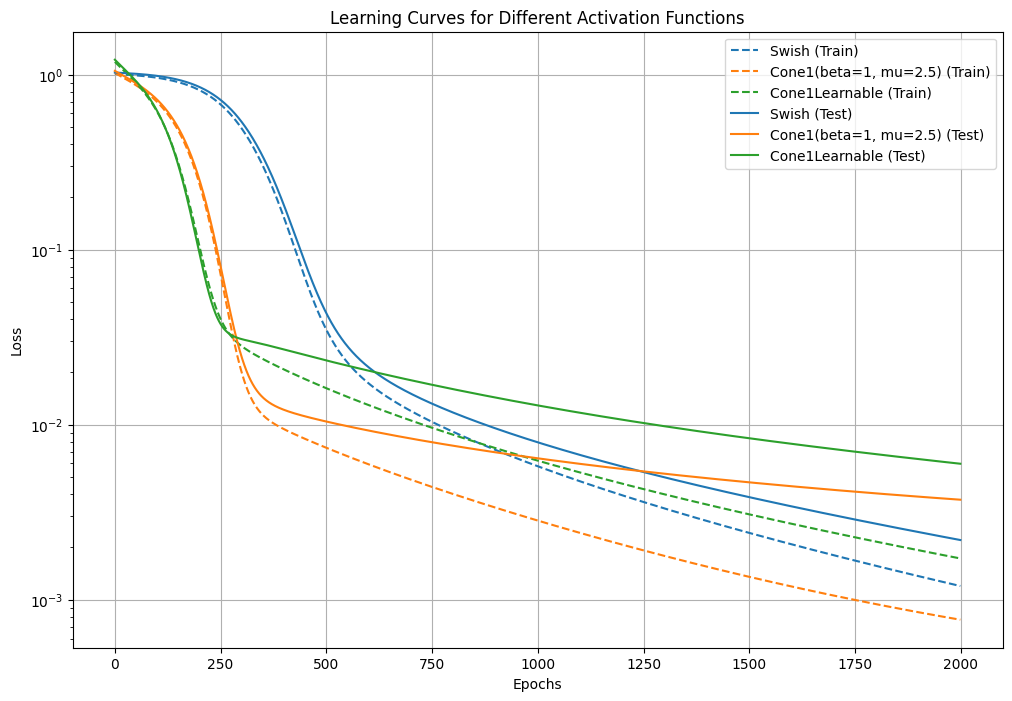

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import erf

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define Cone1 with fixed beta and mu
class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define Learnable Cone1
class Cone1Learnable(nn.Module):
    def __init__(self):
        super(Cone1Learnable, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

# Define ReLU(Cone1(beta=1, mu=2.5))
class ReLU_Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(ReLU_Cone1, self).__init__()
        self.cone1 = Cone1(beta, mu)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.cone1(x))

# Define Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function
def train_model(model, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3
num_epochs = 2000
learning_rate = 0.0001

# Define activation functions
activation_functions = {
    "Swish": Swish(),
    "Cone1(beta=1, mu=2.5)": Cone1(beta=1, mu=2.5),
    "Cone1Learnable": Cone1Learnable(),
#    "ReLU(Cone1(beta=1, mu=2.5))": ReLU_Cone1(beta=1, mu=2.5)
}

# Train and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, num_epochs, learning_rate)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()


# ?. Pruning the network

Since Cone yields better train loss than Swish, we might be able to improve its performance by some explicit regularization techniques, say pruning.

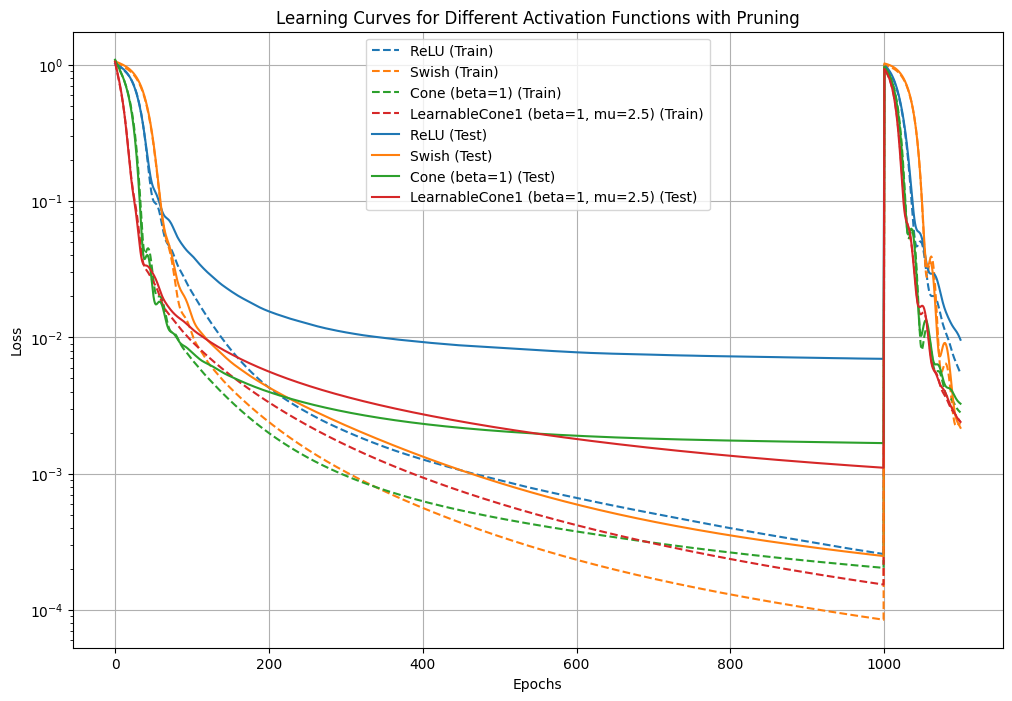

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import erf

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

class LearnableCone1(nn.Module):
    def __init__(self):
        super(LearnableCone1, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.mu = nn.Parameter(torch.tensor(2.5))

    def forward(self, x):
        beta_pos = torch.nn.functional.softplus(self.beta)
        mu_pos = torch.nn.functional.softplus(self.mu)
        return 1 - abs1(1 - x, mu_pos)**beta_pos

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function
def train_model(model, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

# Apply pruning to the model
def apply_pruning(model, amount=0.5):
    parameters_to_prune = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            parameters_to_prune.append((layer, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # Remove pruning reparameterization to make it permanent
    for layer, _ in parameters_to_prune:
        prune.remove(layer, 'weight')

# Fine-tune the pruned model
def fine_tune_model(model, num_epochs=100, learning_rate=0.001):
    return train_model(model, num_epochs, learning_rate)

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
num_layers = 3
num_epochs = 1000
fine_tune_epochs = 100
learning_rate = 0.001

# Define activation functions
activation_functions = {
    "ReLU": nn.ReLU(),
    "Swish": Swish(),
    "Cone (beta=1)": Cone1(beta=1, mu=2.5),
    "LearnableCone1 (beta=1, mu=2.5)": LearnableCone1()
}

# Train, prune, fine-tune, and collect losses for each activation function
train_losses_dict = {}
test_losses_dict = {}

for activation_name, activation_function in activation_functions.items():
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    train_losses, test_losses = train_model(model, num_epochs, learning_rate)

    apply_pruning(model, amount=0.9)
    fine_tune_train_losses, fine_tune_test_losses = fine_tune_model(model, fine_tune_epochs, learning_rate)

    train_losses.extend(fine_tune_train_losses)
    test_losses.extend(fine_tune_test_losses)

    train_losses_dict[activation_name] = train_losses
    test_losses_dict[activation_name] = test_losses

# Define a color map
colors = list(plt.cm.tab10.colors)

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, (activation_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Train)", color=colors[i], linestyle='dashed')

for i, (activation_name, losses) in enumerate(test_losses_dict.items()):
    plt.plot(losses, label=f"{activation_name} (Test)", color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Learning Curves for Different Activation Functions with Pruning')
plt.legend()
plt.grid(True)
plt.show()


# ?. Classification vs Regression Task

Is there a difference in test performance in classification and regresion task?

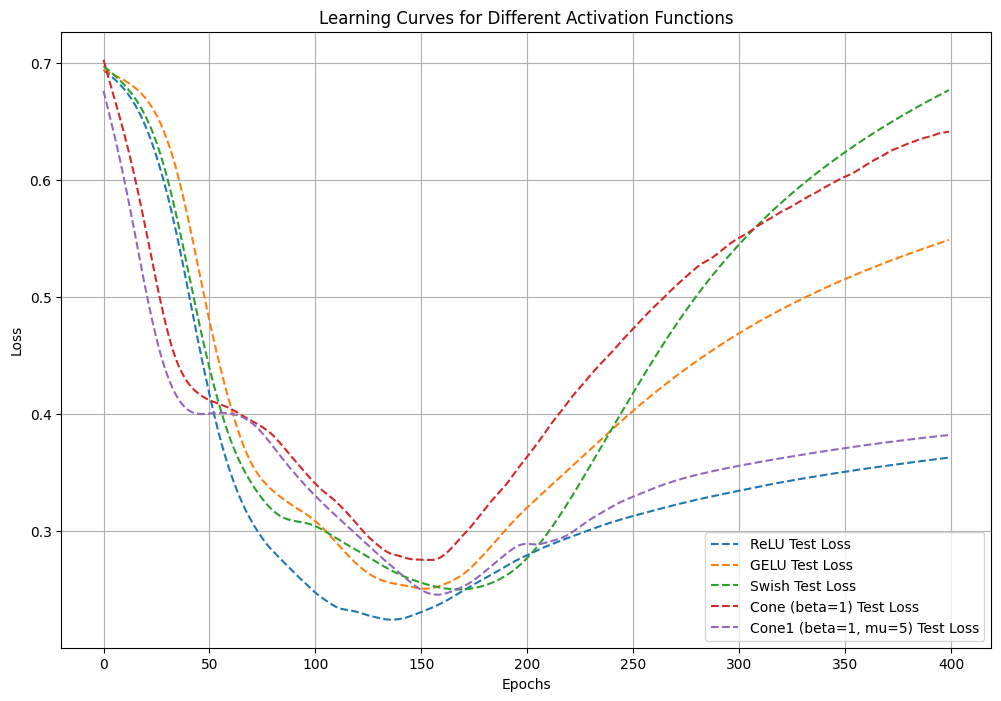

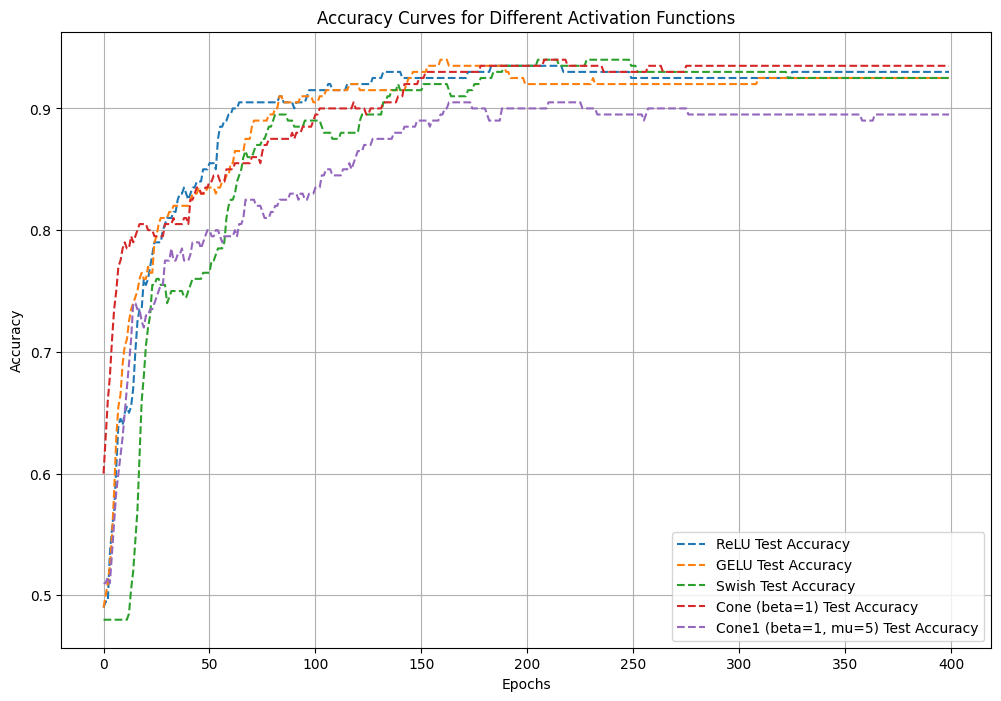

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define custom activation functions
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Cone(nn.Module):
    def __init__(self, beta):
        super(Cone, self).__init__()
        self.beta = beta

    def forward(self, x):
        return 1 - torch.abs(1 - x)**self.beta

class Cone1(nn.Module):
    def __init__(self, beta, mu):
        super(Cone1, self).__init__()
        self.beta = beta
        self.mu = mu

    def forward(self, x):
        return 1 - abs1(1 - x, self.mu)**self.beta

# Define abs1 function
def abs1(x, mu):
    return x * torch.erf(mu * x)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = activation_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Training function
def train_model(activation_function, num_epochs=100, learning_rate=0.001):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        train_accuracy = (predicted == y_train).sum().item() / y_train.size(0)
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0)
            test_accuracies.append(test_accuracy)

    return train_losses, test_losses, train_accuracies, test_accuracies

# Generate synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 2  # Number of classes
num_layers = 3
num_epochs = 400

# Define activation functions
relu = nn.ReLU()
gelu = nn.GELU()
swish = Swish()
cone = Cone(beta=1)
cone1 = Cone1(beta=1, mu=5)

# Define the activation functions dictionary
activation_functions = {
    "ReLU": relu,
    "GELU": gelu,
    "Swish": swish,
    "Cone (beta=1)": cone,
    "Cone1 (beta=1, mu=5)": cone1
}

# Train and plot learning curves for each activation function
plt.figure(figsize=(12, 8))
for activation_name, activation_function in activation_functions.items():
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(activation_function, num_epochs=num_epochs)

    #plt.plot(train_losses, label=f'{activation_name} Train Loss', linestyle='solid')
    plt.plot(test_losses, label=f'{activation_name} Test Loss', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for activation_name, activation_function in activation_functions.items():
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(activation_function, num_epochs=num_epochs)

    #plt.plot(train_accuracies, label=f'{activation_name} Train Accuracy', linestyle='solid')
    plt.plot(test_accuracies, label=f'{activation_name} Test Accuracy', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Training function
def train_model(activation_function, num_epochs=100, learning_rate=0.001):
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0)

    return test_accuracy

# Generate synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 2  # Number of classes
num_layers = 3
num_epochs = 300
num_iterations = 10

# Define activation functions
relu = nn.ReLU()
gelu = nn.GELU()
swish = Swish()
cone = Cone(beta=1)
cone1 = Cone1(beta=1, mu=5)

# Define the activation functions dictionary
activation_functions = {
    "ReLU": relu,
    "GELU": gelu,
    "Swish": swish,
    "Cone (beta=1)": cone,
    "Cone1 (beta=1, mu=5)": cone1
}

# Run training for each activation function and store results
results = {}
for activation_name, activation_function in activation_functions.items():
    accuracies = []
    for _ in range(num_iterations):
        accuracy = train_model(activation_function, num_epochs=num_epochs)
        accuracies.append(accuracy)
    median_accuracy = np.median(accuracies)
    results[activation_name] = median_accuracy

# Print median accuracy for each activation function
for activation_name, median_accuracy in results.items():
    print(f"{activation_name}: Median Test Accuracy = {median_accuracy:.4f}")

ReLU: Median Test Accuracy = 0.9275
GELU: Median Test Accuracy = 0.9250
Swish: Median Test Accuracy = 0.9200
Cone (beta=1): Median Test Accuracy = 0.9150
Cone1 (beta=1, mu=5): Median Test Accuracy = 0.9175


In [ ]:
# Training function
def train_model(activation_function, num_epochs=100, learning_rate=0.001):
    model = MLP(input_dim, hidden_dim, output_dim, num_layers, activation_function)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    return test_loss.item()

# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1, 1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define constants
input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = 1  # Single continuous output
num_layers = 3
num_epochs = 300
num_iterations = 100

# Define activation functions
relu = nn.ReLU()
gelu = nn.GELU()
swish = Swish()
cone = Cone(beta=1)
cone1 = Cone1(beta=1, mu=5)

# Define the activation functions dictionary
activation_functions = {
    "ReLU": relu,
    "GELU": gelu,
    "Swish": swish,
    "Cone (beta=1)": cone,
    "Cone1 (beta=1, mu=5)": cone1
}

# Run training for each activation function and store results
results = {}
for activation_name, activation_function in activation_functions.items():
    test_losses = []
    for _ in range(num_iterations):
        test_loss = train_model(activation_function, num_epochs=num_epochs)
        test_losses.append(test_loss)
    median_test_loss = np.median(test_losses)
    results[activation_name] = median_test_loss

# Print median test error for each activation function
for activation_name, median_test_loss in results.items():
    print(f"{activation_name}: Median Test Error = {median_test_loss:.4f}")

NameError: name 'make_regression' is not defined